# MATH 582 Final Project
Author: Jace Kline 2881618

### Project Description & Motivation

In this project, I aim to use health and fitness metrics scraped from my personal Garmin Connect account to analyze correlational relationships and perform dimensionality reduction, regression, classification, and clustering. The data is scraped from the time period of mid-June through mid-November 2021 and tracks metrics at both daily and weekly time scales. The metrics observed in the data sets include Calories burned, stress level, resting heart rate (BPM), steps, intensity minutes, and sleep hours. I chose this project because of my recent entrance into the world of endurance sports. I aim to leverage data science techniques to derive useful and interesting results for myself as I continue on my endurance sports journey.


In [2]:
# imports

# base
import pandas as pd
import numpy as np
import time
from itertools import cycle, islice

# plotting
import matplotlib.pyplot as mp
import seaborn as sb
from IPython.display import display

# dimensionality reduction, feature selection, data splitting
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector

# regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, ARDRegression

# classification
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# clustering
from sklearn.cluster import AffinityPropagation, MeanShift, DBSCAN, OPTICS

In [3]:
# load the cleaned data sets
dataloc = "./data/cleaned/"

daily = pd.read_csv(dataloc + "daily.csv").set_index('Date')
weekly = pd.read_csv(dataloc + "weekly.csv").set_index('Week')

dataset_labels = ["Daily", "Weekly"]
datasets = [daily, weekly]

In [4]:
def iterate_datasets(procedure):
    for df, lbl in zip(datasets, dataset_labels):
        procedure(df, lbl)

## Data Sets

In this section, we will describe and show the data sets used in the project. As discussed previously, the data comes from Garmin Connect and exists across daily and weekly time granularities. Hence, we utilize a daily and weekly data set. The data sets and their associated features are listed below:

* Daily metrics
  * Date
  * Intensity Minutes - the amount of time in a given day spent doing intense exercise
  * Steps - the number of steps taken in a given day
  * BPM - the average resting heart rate for a given day
  * Calories - the total number of calories burned in a given day
  * Stress Level - a Garmin score indicating the level of stress exhibited in a given day
  * Sleep Hrs - the number of hours slept for a given night
  * Sleep Hrs Prev - the number of hours slept the previous night


* Weekly metrics
  * Week - the date marking the first day of a seven day period
  * Intensity Minutes - the total intensity minutes in a given week
  * Steps - the average daily steps for a given week
  * BPM - the average resting heart rate over a given week
  * Calories - the total number of calories burned in a given week
  * Stress Level - The average daily stress level (Garmin score) over a given week
  * Sleep Hrs - The average number of hours slept per night over the course of a given week

In [5]:
# display the structure of the data sets

display(daily)
display(weekly)

,Intensity Minutes,Steps,BPM,Calories,Stress Level,Sleep Hrs,Sleep Hrs Prev
Date,,,,,,,
2021-06-15,134,14759,48,3408,29,8.3,8.2
2021-06-16,52,10272,47,2826,28,7.6,8.3
2021-06-17,37,11713,46,2733,26,7.5,7.6
2021-06-18,288,8882,45,3803,30,7.8,7.5
2021-06-19,196,18969,45,3850,23,8.1,7.8
...,...,...,...,...,...,...,...
2021-11-17,0,18255,45,2568,35,6.4,7.9
2021-11-18,196,10532,50,3991,28,7.6,6.4
2021-11-19,139,11221,47,3899,30,6.8,7.6


,Intensity Minutes,Steps,BPM,Calories,Stress Level,Sleep Hrs
Week,,,,,,
2021-06-13,1062,104222,46,23725,28,7.3
2021-06-20,1391,81915,43,25984,26,8.0
2021-06-27,1185,87592,42,26098,25,7.6
2021-07-04,980,75470,40,23457,20,8.2
2021-07-11,923,95418,42,26423,26,7.7
2021-07-18,1504,97509,40,29752,23,7.8
2021-07-25,1079,81498,40,26396,26,7.6
2021-08-01,940,99351,40,26122,23,7.8
2021-08-08,1089,107402,39,25927,22,7.6


## Feature Correlation

In this section, we aim to show the correlation plots of features in our datasets that feature metrics broken down by day and week. These different levels of granularity offer unique insights into the relationship of our different health metrics over the course of time. The results that we obtain in this section will help us narrow the scope and focus for further analysis.

### Method

For each the daily and the weekly data sets, we will utilize Pandas to output the correlation matrix between the data set features. From this correlation matrix, we use the Seaborn library to display a heat map of the correlations between the features.

Daily Correlations:


,Intensity Minutes,Steps,BPM,Calories,Stress Level,Sleep Hrs,Sleep Hrs Prev
Intensity Minutes,1.000000,-0.004423,0.013482,0.892197,0.230601,-0.008631,-0.034139
Steps,-0.004423,1.000000,0.033033,0.020973,0.117554,-0.037931,-0.010435
BPM,0.013482,0.033033,1.000000,-0.053743,0.541332,-0.104375,-0.204297
Calories,0.892197,0.020973,-0.053743,1.000000,0.213655,-0.053092,0.005453
Stress Level,0.230601,0.117554,0.541332,0.213655,1.000000,-0.284637,-0.066463
Sleep Hrs,-0.008631,-0.037931,-0.104375,-0.053092,-0.284637,1.000000,0.020246
Sleep Hrs Prev,-0.034139,-0.010435,-0.204297,0.005453,-0.066463,0.020246,1.000000


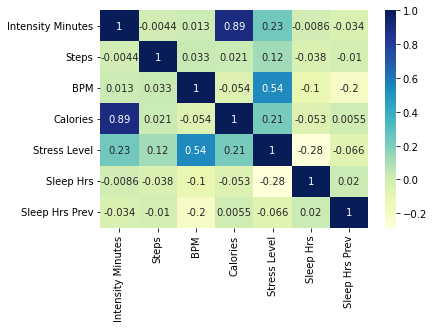

Weekly Correlations:


,Intensity Minutes,Steps,BPM,Calories,Stress Level,Sleep Hrs
Intensity Minutes,1.000000,0.484602,-0.166824,0.803882,0.052529,-0.112213
Steps,0.484602,1.000000,0.031067,0.549071,0.102130,-0.153504
BPM,-0.166824,0.031067,1.000000,-0.329999,0.714542,-0.304279
Calories,0.803882,0.549071,-0.329999,1.000000,0.031148,-0.117699
Stress Level,0.052529,0.102130,0.714542,0.031148,1.000000,-0.364152
Sleep Hrs,-0.112213,-0.153504,-0.304279,-0.117699,-0.364152,1.000000


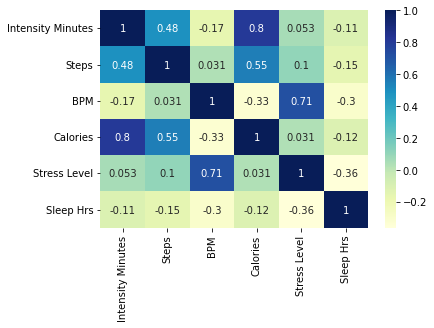

In [6]:
def display_correlations(df, lbl):
    print(f"{lbl} Correlations:")
    corr = df.corr()
    display(corr)
    
    sb.heatmap(corr, cmap="YlGnBu", annot=True)
    mp.show()

# for lbl, df in zip(dataset_labels, datasets):
#     display_correlations(df, lbl)

iterate_datasets(display_correlations)

### Discussion

These correlation plots show us that the number of hours of sleep per night are negatively correlated with nearly all other features. This is most pronounced on the weekly scale as opposed to the daily scale. We note the sleep per night is significantly negatively correlated with stress level which indicates a stressful day is linked to poorer sleep. This plays out across the weekly time scale as well. Additionally, we see that stress level and resting heart rate (BPM) are significantly positively correlated in both the daily and weekly time scales. This indicates that both acute and prolonged stress associate with an increase in heart rate. We also see that an increase in intensity minutes in a given day is an indicator of a higher stress level. However, this does not play out at the weekly time scale. Intuitively, we see that steps, intensity minutes, and Calories burned are all significantly positively correlated. The overlapping information stored within these data set features presents the possiblility of accurate dimensionality reduction via PCA or SVD, which we shall discuss in the next section.

## Dimensionality Reduction (PCA & SVD)

As touched on in the feature correlation discussion, the shared information and high correlations present between features in the data present the possible success of dimensionality reduction using principal component analysis (PCA) and singular value decomposition (SVD) on the data. The dimension-reduced data sets can then be utilized in further models leveraging these data sets. Later in this report we will utilize the 2-dimensional PCA reduction on the data sets to show the clustering of data points on a 2D plane.

### Method

The first step is to define functions that perform both SVD and PCA reduction to the required dimension. After this, we define a function that takes a data set, computes the error between the original and the data-reduced using the Frobenius Norm of the difference between the original and dimension-reduced matrices from dimensions 1 to D (the number of features in the original data set), and then return a table capturing the results. We then plot the SVD and PCA errors from this resulting table as a function of the dimension.

In [7]:
# SVD Reducer function

# X: Data set with D columns (features), N rows (samples)
# M: the number of dimensions to reduce to where M <= D
def svd_reduce(X, M):
    U, singular_values, Vt = np.linalg.svd(X.T, full_matrices=False, compute_uv=True)
    Sigma = np.diag(singular_values)
    return (U[:,0:M] @ Sigma[0:M,0:M] @ Vt[0:M,:]).T

In [8]:
# PCA Reducer function

# X: Data set with D columns (features), N rows (samples)
# M: the number of dimensions to reduce to where M <= D
# transforms the shape of data matrix back to original space
def pca_reduce(X, M):
    pca = PCA(n_components=M)
    return pca.inverse_transform(pca.fit_transform(X))

In [9]:
def svd_vs_pca_err(X):
    N, D = X.shape
    results = []

    for M in range(1, D):
        svd_err = np.linalg.norm(X - svd_reduce(X, M))
        pca_err = np.linalg.norm(X - pca_reduce(X, M))
        results.append((M, svd_err, pca_err))

    return pd.DataFrame(results, columns=['Dimensions', 'SVD Error', 'PCA Error']).set_index('Dimensions')

def dim_reduction_results(df, lbl):
    print(f"SVD vs PCA on the {lbl} data set:")
    res = svd_vs_pca_err(df.to_numpy())
    display(res)
    res.plot(kind='bar', logy=True)
    mp.show()

SVD vs PCA on the Daily data set:


,SVD Error,PCA Error
Dimensions,,
1,21358.531618,8360.076702
2,899.862704,567.015938
3,112.933926,85.590116
4,50.662280,40.945510
5,18.716781,15.823564
6,11.047249,10.993506


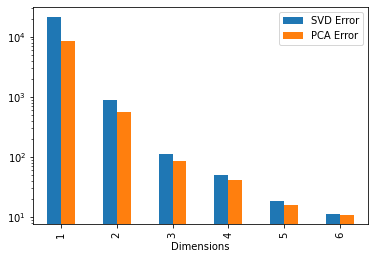

SVD vs PCA on the Weekly data set:


,SVD Error,PCA Error
Dimensions,,
1,20126.822675,7443.067632
2,1005.308563,779.209994
3,32.182790,25.371795
4,11.706628,8.511178
5,2.625951,2.121780


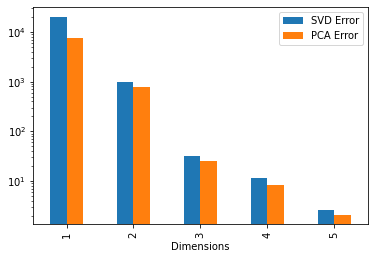

In [10]:
iterate_datasets(dim_reduction_results)

### Discussion

The results above indicate to us that dimensionality reduction on our target data sets is feasible and fairly accurate when using at least 3 dimensions. We utilized the Frobenius Norm function to measure the error the PCA and SVD methods. We see that the the PCA reduction resulted in more accurate information preservation than that of the SVD reduction. The success of PCA in this case can be explained by the relatively high redundancy, and therefore covariance, exhibited via the similarities in features such as Calories burned, intensity minutes, and steps.

## Regression

In this section, we aim to utilize regression to predict the following features as a function of the other features: Intensity Minutes, Calories, Stress Level, and Sleep Hrs. We additionally utilize multiple regression models and feature selection techniques for comparison of model predictive performance on the target features. The ultimate goal in this analysis is to find which target features can reliably be predicted using regression in the context of our daily and weekly data sets.

### Method

To achieve successful regression results, we must first prune our data set features to only utilize features that result in useful predictive outcomes for the given problem at hand. To achieve this, we utilize the forward sequential feature selector offered by SciKit-Learn to test different combinations of features on a given regression input model. We choose the set of features that performs the highest for a given model. The SciKit-Learn regression models used in our tests are as follows: LinearRegression, Lasso, Ridge, ElasticNet, and ARDRegression. We iterate over each of the data sets, models, and target features and perform regression model training and testing. For each of the target features, we record the accuracy and the time overhead of each model in a table. We additionally plot the performance of each model across the different data sets and features. Lastly, we compile all the results and then analyze the models, highlighting which models are most accurate and efficient across the data sets and features.

In [11]:
# Split the input DataFrame (df) into X and y based on the target regression feature name (y_feature)
def split_dataset(df, y_feature):
    
    X_features = np.array(df.columns)
    X_features = X_features[X_features != y_feature]

    X = df[X_features]
    y = df[y_feature]
    return X, y

# Find the optimal features for the given target
# return the optimal features, the score of the model on the training data, and the score of the model on the testing data
def evaluate_model(X, y, model):
    
    feature_selector = SequentialFeatureSelector(model, k_features='best', n_jobs=-1)

    feature_selector.fit(X, y)
    optimal_features = list(feature_selector.k_feature_names_)

    X_train, X_test, y_train, y_test = train_test_split(X[optimal_features], y, random_state=57)

    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    return optimal_features, train_score, test_score

In [12]:
# The SciKit Learn regression models to test
model_labels = ["LinearRegression", "Lasso", "Ridge", "ElasticNet", "ARDRegression"]
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), ARDRegression()]

# output the results of running all of the above regression models on the input data set and target feature
def regression_tests(df, df_lbl, y_feature):
    results = []
    X, y = split_dataset(df, y_feature)

    for model, lbl in zip(models, model_labels):
        start = time.time()
        ftrs, train_score, test_score = evaluate_model(X, y, model)
        time_taken = time.time() - start
        results.append((lbl, ftrs, train_score, test_score, time_taken))

    res_table = pd.DataFrame(results, columns=['Model Type', 'Feature Inputs', 'Train Score', 'Test Score', 'Time Taken']).set_index('Model Type') 
    print("Feature Selector: Forward Sequential")
    print(f"Data Set: {df_lbl}")
    print(f"Prediction Feature: {y_feature}")
    display(res_table)
    res_table[['Train Score', 'Test Score']].plot(
        kind='bar',
        title=f"Results of predicting feature '{y_feature}' on the {df_lbl} data set"
    )
    mp.show()
    return res_table


Feature Selector: Forward Sequential
Data Set: Daily
Prediction Feature: Intensity Minutes


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
LinearRegression,[Calories],0.785426,0.788369,1.800118
Lasso,[Calories],0.785426,0.788366,0.081886
Ridge,[Calories],0.785426,0.788369,0.095631
ElasticNet,"[Calories, Sleep Hrs Prev]",0.785836,0.789875,0.069020
ARDRegression,"[Steps, Calories]",0.785421,0.787917,0.161802


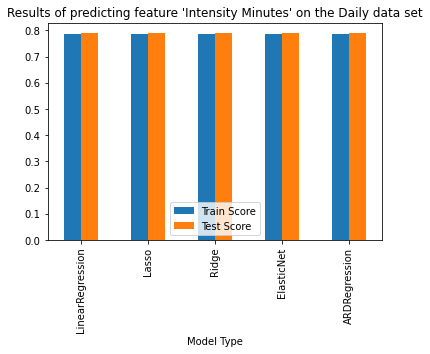

Feature Selector: Forward Sequential
Data Set: Daily
Prediction Feature: Calories


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
LinearRegression,"[Intensity Minutes, Sleep Hrs Prev]",0.786311,0.806465,0.085224
Lasso,"[Intensity Minutes, Sleep Hrs Prev]",0.786308,0.806371,0.087633
Ridge,"[Intensity Minutes, Sleep Hrs Prev]",0.786311,0.806449,0.082263
ElasticNet,"[Intensity Minutes, Sleep Hrs Prev]",0.786204,0.805781,0.072023
ARDRegression,[Intensity Minutes],0.785421,0.804510,0.216270


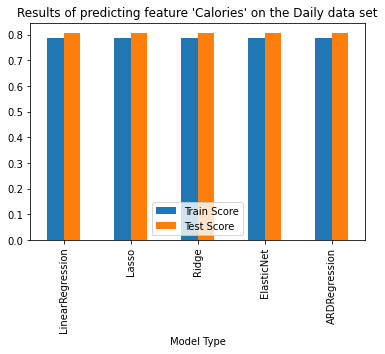

Feature Selector: Forward Sequential
Data Set: Daily
Prediction Feature: Stress Level


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
LinearRegression,"[Steps, BPM, Calories, Sleep Hrs]",0.394941,0.408364,0.074272
Lasso,"[Steps, BPM, Calories, Sleep Hrs]",0.361740,0.322168,0.083774
Ridge,"[Steps, BPM, Calories, Sleep Hrs]",0.394938,0.407816,0.084711
ElasticNet,"[Steps, BPM, Calories, Sleep Hrs]",0.378514,0.353470,0.079546
ARDRegression,"[Steps, BPM, Sleep Hrs]",0.327733,0.368451,0.137450


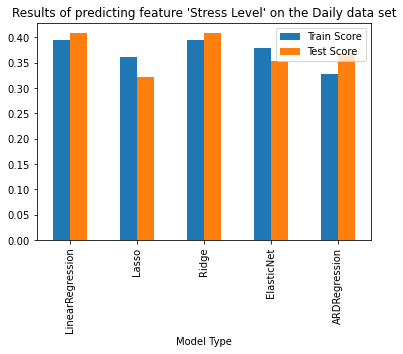

Feature Selector: Forward Sequential
Data Set: Daily
Prediction Feature: Sleep Hrs


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
LinearRegression,[Stress Level],0.049312,0.154644,0.071658
Lasso,[Stress Level],0.013159,0.003797,0.084935
Ridge,[Stress Level],0.049312,0.154609,0.086350
ElasticNet,[Stress Level],0.039872,0.090200,0.073799
ARDRegression,"[Calories, Stress Level]",0.047890,0.132764,0.095782


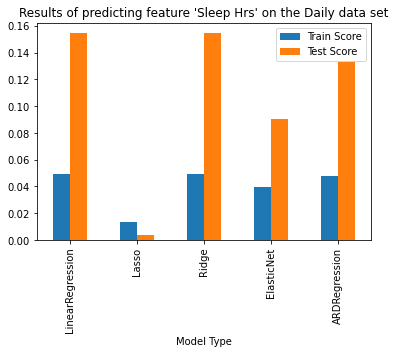

Feature Selector: Forward Sequential
Data Set: Weekly
Prediction Feature: Intensity Minutes


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
LinearRegression,"[Steps, Calories]",0.710347,0.271648,0.062280
Lasso,"[Steps, Calories]",0.710347,0.271649,0.057196
Ridge,"[Steps, Calories]",0.710347,0.271648,0.054176
ElasticNet,"[Steps, Calories]",0.710347,0.271648,0.055804
ARDRegression,[Calories],0.708623,0.275184,0.135886


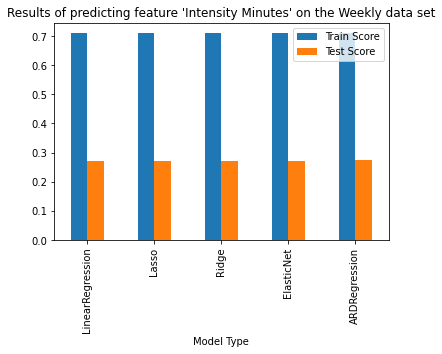

Feature Selector: Forward Sequential
Data Set: Weekly
Prediction Feature: Calories


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
LinearRegression,"[Intensity Minutes, Steps, BPM]",0.790201,0.426081,0.057792
Lasso,"[Intensity Minutes, Steps, BPM]",0.790201,0.426178,0.055767
Ridge,"[Intensity Minutes, Steps, BPM]",0.790199,0.426894,0.049788
ElasticNet,"[Intensity Minutes, Steps, BPM]",0.790087,0.432508,0.057277
ARDRegression,"[Intensity Minutes, Steps, BPM]",0.754408,0.350800,0.151631


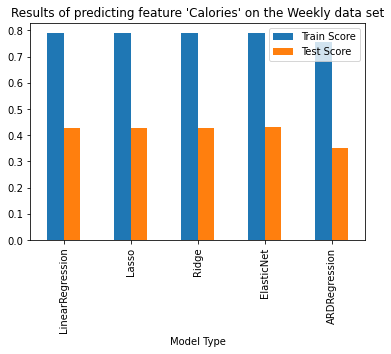

Feature Selector: Forward Sequential
Data Set: Weekly
Prediction Feature: Stress Level


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
LinearRegression,"[BPM, Calories]",0.486903,0.824069,0.059322
Lasso,"[BPM, Calories]",0.481126,0.793232,0.058774
Ridge,"[BPM, Calories]",0.486889,0.822993,0.055857
ElasticNet,"[BPM, Calories]",0.482385,0.797803,0.054898
ARDRegression,"[Intensity Minutes, BPM, Calories, Sleep Hrs]",0.428475,0.645244,0.112154


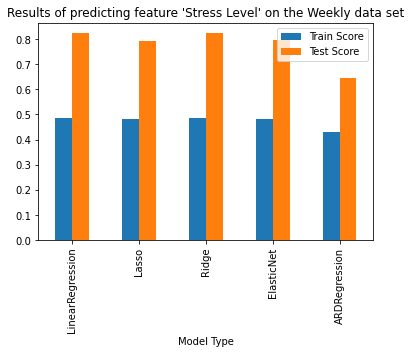

Feature Selector: Forward Sequential
Data Set: Weekly
Prediction Feature: Sleep Hrs


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
LinearRegression,[BPM],0.008091,0.081489,0.056303
Lasso,[BPM],0.000000,-0.000038,0.054506
Ridge,[BPM],0.008091,0.081155,0.055642
ElasticNet,[Stress Level],0.000000,-0.000038,0.054830
ARDRegression,[Stress Level],0.000000,-0.000038,0.077323


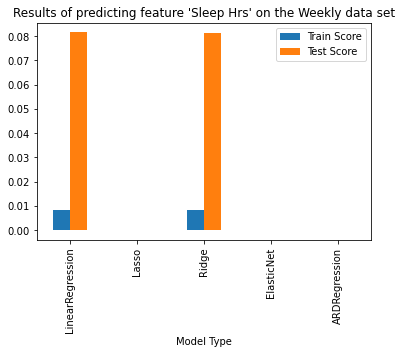

In [13]:
targets = ['Intensity Minutes', 'Calories', 'Stress Level', 'Sleep Hrs']
results = []

# Iterate over the data sets
for df, df_lbl in zip(datasets, dataset_labels):
    # For each data set, perform regression tests on each of the features
    for y_feature in targets:
        res = regression_tests(df, df_lbl, y_feature)
        results.append((f"{y_feature} ({df_lbl})", res))

In [14]:
# compile and show the results for the models across all runs
# show distinct results for predictions on the training and testing data
test_lbls = [test_lbl for test_lbl, _ in results]
for feature in ['Train Score', 'Test Score', 'Time Taken']:
    results_arr = np.vstack([res[feature].to_numpy() for _, res in results])
    model_performances = pd.DataFrame(results_arr, columns=model_labels, index=test_lbls)
    avgs = model_performances.mean()
    best_performer = (min if feature == 'Time Taken' else max)(zip(list(avgs.index), list(avgs)), key=lambda t: t[1])[0]

    print(f"\n\nMeasurement: {feature}")
    display(model_performances)

    print(f"Model Average Performances ({feature})")
    display(avgs)
    print(f"Best Average Performer ({feature}): {best_performer}")



Measurement: Train Score


,LinearRegression,Lasso,Ridge,ElasticNet,ARDRegression
Intensity Minutes (Daily),0.785426,0.785426,0.785426,0.785836,0.785421
Calories (Daily),0.786311,0.786308,0.786311,0.786204,0.785421
Stress Level (Daily),0.394941,0.361740,0.394938,0.378514,0.327733
Sleep Hrs (Daily),0.049312,0.013159,0.049312,0.039872,0.047890
Intensity Minutes (Weekly),0.710347,0.710347,0.710347,0.710347,0.708623
Calories (Weekly),0.790201,0.790201,0.790199,0.790087,0.754408
Stress Level (Weekly),0.486903,0.481126,0.486889,0.482385,0.428475
Sleep Hrs (Weekly),0.008091,0.000000,0.008091,0.000000,0.000000


Model Average Performances (Train Score)


LinearRegression    0.501441
Lasso               0.491038
Ridge               0.501439
ElasticNet          0.496656
ARDRegression       0.479746
dtype: float64

Best Average Performer (Train Score): LinearRegression


Measurement: Test Score


,LinearRegression,Lasso,Ridge,ElasticNet,ARDRegression
Intensity Minutes (Daily),0.788369,0.788366,0.788369,0.789875,0.787917
Calories (Daily),0.806465,0.806371,0.806449,0.805781,0.804510
Stress Level (Daily),0.408364,0.322168,0.407816,0.353470,0.368451
Sleep Hrs (Daily),0.154644,0.003797,0.154609,0.090200,0.132764
Intensity Minutes (Weekly),0.271648,0.271649,0.271648,0.271648,0.275184
Calories (Weekly),0.426081,0.426178,0.426894,0.432508,0.350800
Stress Level (Weekly),0.824069,0.793232,0.822993,0.797803,0.645244
Sleep Hrs (Weekly),0.081489,-0.000038,0.081155,-0.000038,-0.000038


Model Average Performances (Test Score)


LinearRegression    0.470141
Lasso               0.426465
Ridge               0.469992
ElasticNet          0.442656
ARDRegression       0.420604
dtype: float64

Best Average Performer (Test Score): LinearRegression


Measurement: Time Taken


,LinearRegression,Lasso,Ridge,ElasticNet,ARDRegression
Intensity Minutes (Daily),1.800118,0.081886,0.095631,0.069020,0.161802
Calories (Daily),0.085224,0.087633,0.082263,0.072023,0.216270
Stress Level (Daily),0.074272,0.083774,0.084711,0.079546,0.137450
Sleep Hrs (Daily),0.071658,0.084935,0.086350,0.073799,0.095782
Intensity Minutes (Weekly),0.062280,0.057196,0.054176,0.055804,0.135886
Calories (Weekly),0.057792,0.055767,0.049788,0.057277,0.151631
Stress Level (Weekly),0.059322,0.058774,0.055857,0.054898,0.112154
Sleep Hrs (Weekly),0.056303,0.054506,0.055642,0.054830,0.077323


Model Average Performances (Time Taken)


LinearRegression    0.283371
Lasso               0.070559
Ridge               0.070552
ElasticNet          0.064650
ARDRegression       0.136037
dtype: float64

Best Average Performer (Time Taken): ElasticNet


### Discussion

The above results show us that some of the features are much better suited to prediction via regression than others. Particularly, predicting the following metrics lead to respectable results: daily intensity minutes, daily Calories, and weekly stress level. The lack of accuracy in performing regression across the other features displays the fact that our data lacks necessary information required for us to make reasonable predictions on those features. Data is simply a rough snapshot of a subset of important factors that could dictate the outcome of a phenomemon in the real world, and it is evident that predicting factors such as sleep hours, resting heart rate, and other features requires additional information not captured in our data.

Another interesting observation that arises from our results above is the fact that the number of optimal features in each of the regression models is nearly always a proper subset of the total set of features. This implies that some of the features or combinations of the features being utilized in the model may actually result in reduced accuracy through overfitting or addition of noise. This highlights the fact that more features are not always better when constructing a model.

Lastly, we show the comparison of regression predictions across the different models used. This comparison data highlights that all the tested models behaved similarly across the test runs. However, the LinearRegression and Ridge models performed best overall in terms of predictive accuracy. We also see that the ElasticNet model had the lowest time overhead amongst the models tested.

## Classification

In this section, we perform binary classification on the same target features used in the regression tests above. These include Intensity Minutes, Calories, Stress Level, and Sleep Hrs. To turn this into a binary classification problem, we find the mean for each target feature and create a classification label indicating whether a data point has target feature above (+1) or below (-1) the median.

### Method

The method used in this section is similar to the method used in the regression analysis. We iterate over each of the data sets, target features, and models and perform binary classification fitting and testing. We record the results and display plots comparing the accuracy of each of the models for a given target feature and data set. Lastly, we compare the models for accuracy and efficiency and highlight the best average performers. The binary classification models used in this analysis are SVC (polynomial kernel), SVC (RBF kernel), GaussianNB, MultinomialNB, SGDClassifier, DecisionTreeClassifier, and RandomForestClassifier. These models are all implemented in SciKit-Learn.

In [15]:
def split_dataset_classification(df, y_feature):
    X, y = split_dataset(df, y_feature)
    threshold = y.median()
    y_classification = (y >= threshold).apply(lambda b: 1 if b else -1)
    return X, y, y_classification, threshold

In [16]:
# The SciKit Learn classification models to test
svc_kernels = ['poly', 'rbf']
model_labels = [f'SVC (kernel = {kernel})' for kernel in svc_kernels] +\
    ["GaussianNB", "MultinomialNB", "SGDClassifier", "DecisionTreeClassifier", "RandomForestClassifier"]
models = [SVC(kernel=kernel) for kernel in svc_kernels] +\
    [GaussianNB(), MultinomialNB(), SGDClassifier(), DecisionTreeClassifier(), RandomForestClassifier()]

# output the results of running all of the above regression models on the input data set and target feature
def classification_tests(df, df_lbl, y_feature):
    results = []
    X, y, y_classification, threshold = split_dataset_classification(df, y_feature)

    for model, lbl in zip(models, model_labels):
        start = time.time()
        ftrs, train_score, test_score = evaluate_model(X, y_classification, model)
        time_taken = time.time() - start
        results.append((lbl, ftrs, train_score, test_score, time_taken))

    res_table = pd.DataFrame(results, columns=['Model Type', 'Feature Inputs', 'Train Score', 'Test Score', 'Time Taken']).set_index('Model Type') 
    print("Feature Selector: Forward Sequential")
    print(f"Data Set: {df_lbl}")
    print(f"Prediction Feature: {y_feature}")
    print(f"Classification Threshold: {threshold}")
    display(res_table)
    res_table[['Train Score', 'Test Score']].plot(
        kind='bar',
        title=f"Results of classifying feature '{y_feature}' on the {df_lbl} data set above or below threshold {threshold}"
    )
    mp.show()
    return res_table

Feature Selector: Forward Sequential
Data Set: Daily
Prediction Feature: Intensity Minutes
Classification Threshold: 170.0


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
SVC (kernel = poly),[Calories],0.885965,0.846154,4.637491
SVC (kernel = rbf),"[BPM, Calories]",0.885965,0.846154,0.078997
GaussianNB,"[Steps, Calories]",0.894737,0.846154,0.080918
MultinomialNB,"[Steps, Calories]",0.578947,0.589744,0.069189
SGDClassifier,"[Steps, Calories, Sleep Hrs Prev]",0.535088,0.384615,0.070626
DecisionTreeClassifier,"[Steps, Calories]",1.000000,0.846154,0.093363
RandomForestClassifier,"[Steps, Calories]",1.000000,0.846154,3.200622


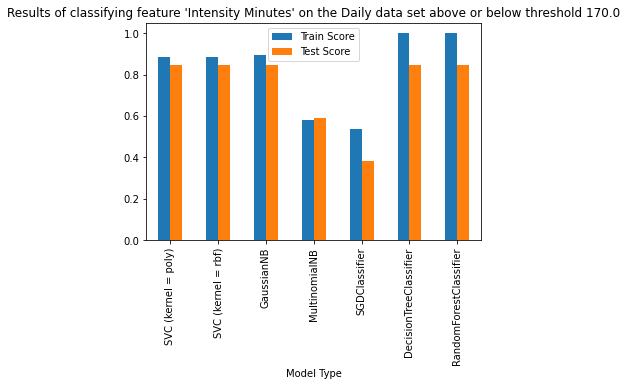

Feature Selector: Forward Sequential
Data Set: Daily
Prediction Feature: Calories
Classification Threshold: 3745.0


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
SVC (kernel = poly),[Intensity Minutes],0.894737,0.820513,2.169618
SVC (kernel = rbf),"[Intensity Minutes, Sleep Hrs]",0.894737,0.820513,0.080157
GaussianNB,"[Intensity Minutes, Steps]",0.921053,0.846154,0.063939
MultinomialNB,"[Intensity Minutes, Sleep Hrs]",0.833333,0.871795,0.069031
SGDClassifier,"[Intensity Minutes, Stress Level, Sleep Hrs]",0.710526,0.794872,0.068698
DecisionTreeClassifier,"[Intensity Minutes, Steps]",1.000000,0.692308,0.064428
RandomForestClassifier,"[Intensity Minutes, Steps, Sleep Hrs]",1.000000,0.794872,3.447528


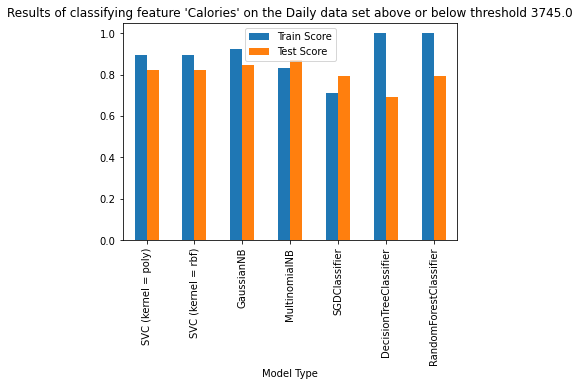

Feature Selector: Forward Sequential
Data Set: Daily
Prediction Feature: Stress Level
Classification Threshold: 27.0


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
SVC (kernel = poly),[BPM],0.701754,0.589744,10.172832
SVC (kernel = rbf),"[BPM, Sleep Hrs Prev]",0.719298,0.589744,0.086881
GaussianNB,"[Intensity Minutes, BPM]",0.763158,0.717949,0.064138
MultinomialNB,"[Intensity Minutes, Calories, Sleep Hrs]",0.614035,0.641026,0.067086
SGDClassifier,"[BPM, Sleep Hrs, Sleep Hrs Prev]",0.508772,0.435897,0.070697
DecisionTreeClassifier,[BPM],0.754386,0.666667,0.063683
RandomForestClassifier,"[Intensity Minutes, BPM, Sleep Hrs]",1.000000,0.794872,3.383195


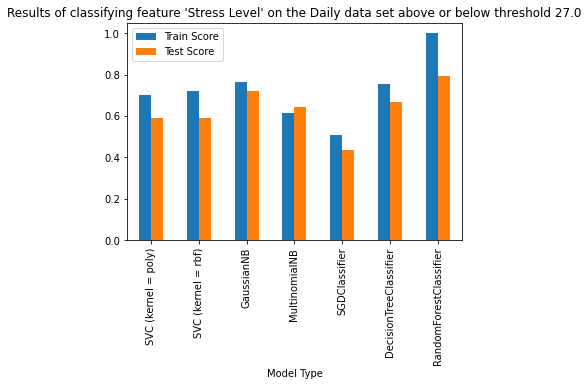

Feature Selector: Forward Sequential
Data Set: Daily
Prediction Feature: Sleep Hrs
Classification Threshold: 7.7


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
SVC (kernel = poly),"[BPM, Stress Level]",0.578947,0.589744,5.440332
SVC (kernel = rbf),[Calories],0.605263,0.512821,0.086750
GaussianNB,"[Steps, BPM, Calories, Stress Level, Sleep Hrs...",0.587719,0.589744,0.065648
MultinomialNB,"[Intensity Minutes, Calories]",0.535088,0.564103,0.065448
SGDClassifier,"[Intensity Minutes, BPM, Calories, Stress Level]",0.517544,0.487179,0.066730
DecisionTreeClassifier,"[Steps, BPM, Calories]",1.000000,0.589744,0.068310
RandomForestClassifier,[Stress Level],0.684211,0.615385,3.347081


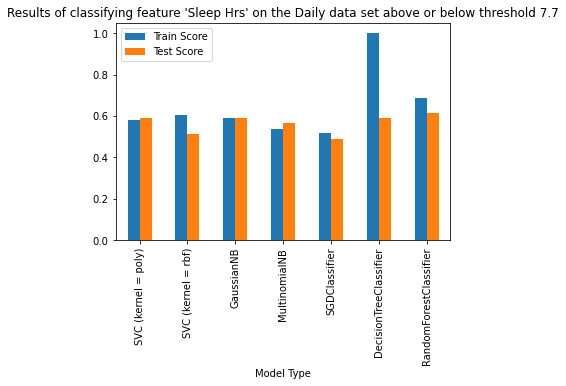

Feature Selector: Forward Sequential
Data Set: Weekly
Prediction Feature: Intensity Minutes
Classification Threshold: 1158.0


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
SVC (kernel = poly),"[Steps, Calories]",0.705882,0.666667,0.579070
SVC (kernel = rbf),[Calories],0.764706,0.500000,0.056272
GaussianNB,"[BPM, Calories, Sleep Hrs]",0.764706,0.333333,0.048931
MultinomialNB,"[Steps, Sleep Hrs]",0.588235,0.333333,0.051062
SGDClassifier,"[BPM, Calories]",0.588235,0.333333,0.049393
DecisionTreeClassifier,"[Steps, Calories, Stress Level]",1.000000,0.666667,0.047271
RandomForestClassifier,"[Calories, Stress Level]",1.000000,0.666667,2.583588


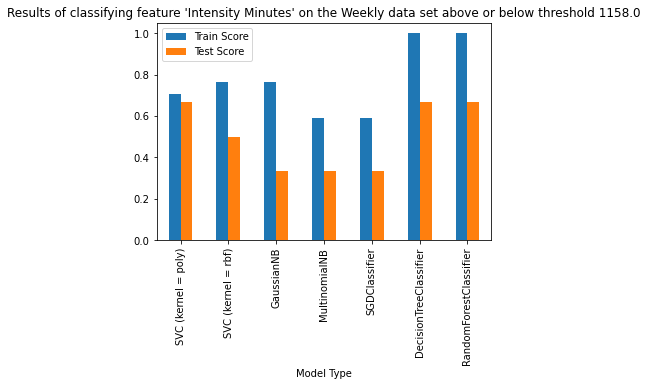

Feature Selector: Forward Sequential
Data Set: Weekly
Prediction Feature: Calories
Classification Threshold: 26098.0


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
SVC (kernel = poly),[Intensity Minutes],0.823529,0.666667,1.972036
SVC (kernel = rbf),"[Intensity Minutes, BPM, Stress Level]",0.764706,0.666667,0.053296
GaussianNB,"[Intensity Minutes, Steps, BPM]",0.764706,0.666667,0.052269
MultinomialNB,"[Intensity Minutes, BPM]",0.882353,0.666667,0.054725
SGDClassifier,"[Intensity Minutes, Steps, BPM, Stress Level, ...",0.470588,0.666667,0.051813
DecisionTreeClassifier,"[Steps, BPM]",1.000000,0.833333,0.046210
RandomForestClassifier,"[Steps, BPM, Sleep Hrs]",1.000000,1.000000,2.940507


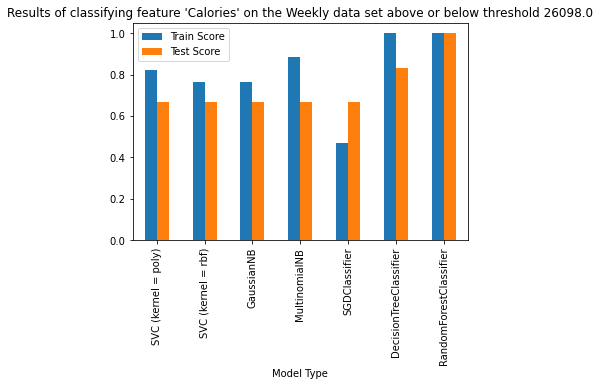

Feature Selector: Forward Sequential
Data Set: Weekly
Prediction Feature: Stress Level
Classification Threshold: 26.0


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
SVC (kernel = poly),[Intensity Minutes],0.647059,0.666667,2.085243
SVC (kernel = rbf),[BPM],0.705882,1.000000,0.106954
GaussianNB,"[BPM, Calories, Sleep Hrs]",0.647059,0.666667,0.111579
MultinomialNB,"[Intensity Minutes, BPM, Sleep Hrs]",0.647059,0.666667,0.119843
SGDClassifier,[Intensity Minutes],0.647059,0.666667,0.116159
DecisionTreeClassifier,[Sleep Hrs],0.823529,0.500000,0.101258
RandomForestClassifier,"[Calories, Sleep Hrs]",1.000000,0.833333,3.524529


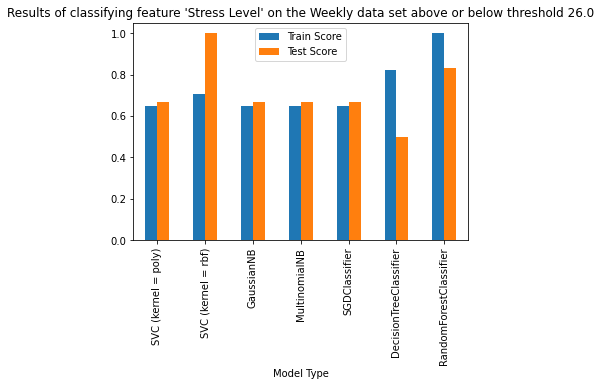

Feature Selector: Forward Sequential
Data Set: Weekly
Prediction Feature: Sleep Hrs
Classification Threshold: 7.6


,Feature Inputs,Train Score,Test Score,Time Taken
Model Type,,,,
SVC (kernel = poly),[BPM],0.705882,1.000000,1.280919
SVC (kernel = rbf),[BPM],0.705882,1.000000,0.080235
GaussianNB,"[Intensity Minutes, Steps, BPM, Stress Level]",0.823529,1.000000,0.103763
MultinomialNB,"[Intensity Minutes, Stress Level]",0.588235,0.500000,0.120851
SGDClassifier,"[Intensity Minutes, Calories, Stress Level]",0.470588,0.333333,0.109230
DecisionTreeClassifier,"[Intensity Minutes, BPM, Calories]",1.000000,0.833333,0.094545
RandomForestClassifier,[BPM],0.882353,0.833333,2.818754


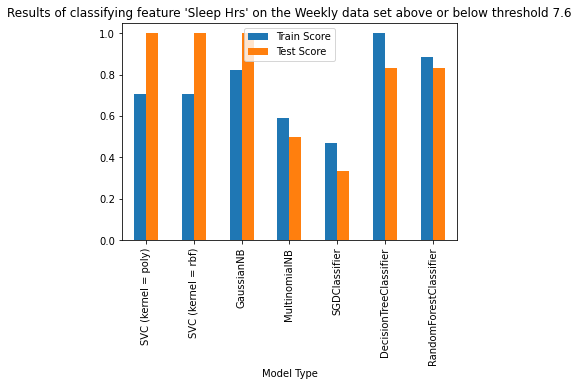

In [17]:
targets = ['Intensity Minutes', 'Calories', 'Stress Level', 'Sleep Hrs']
results = []

# Iterate over the data sets
for df, df_lbl in zip(datasets, dataset_labels):
    # For each data set, perform regression tests on each of the features
    for y_feature in targets:
        res = classification_tests(df, df_lbl, y_feature)
        results.append((f"{y_feature} ({df_lbl})", res))

In [18]:
# compile and show the results for the models across all runs
# show distinct results for predictions on the training and testing data
test_lbls = [test_lbl for test_lbl, _ in results]
for feature in ['Train Score', 'Test Score', 'Time Taken']:
    results_arr = np.vstack([res[feature].to_numpy() for _, res in results])
    model_performances = pd.DataFrame(results_arr, columns=model_labels, index=test_lbls)
    avgs = model_performances.mean()
    best_performer = (min if feature == 'Time Taken' else max)(zip(list(avgs.index), list(avgs)), key=lambda t: t[1])[0]

    print(f"\n\nMeasurement: {feature}")
    display(model_performances)

    print(f"Model Average Performances ({feature})")
    display(avgs)
    print(f"Best Average Performer ({feature}): {best_performer}")



Measurement: Train Score


,SVC (kernel = poly),SVC (kernel = rbf),GaussianNB,MultinomialNB,SGDClassifier,DecisionTreeClassifier,RandomForestClassifier
Intensity Minutes (Daily),0.885965,0.885965,0.894737,0.578947,0.535088,1.000000,1.000000
Calories (Daily),0.894737,0.894737,0.921053,0.833333,0.710526,1.000000,1.000000
Stress Level (Daily),0.701754,0.719298,0.763158,0.614035,0.508772,0.754386,1.000000
Sleep Hrs (Daily),0.578947,0.605263,0.587719,0.535088,0.517544,1.000000,0.684211
Intensity Minutes (Weekly),0.705882,0.764706,0.764706,0.588235,0.588235,1.000000,1.000000
Calories (Weekly),0.823529,0.764706,0.764706,0.882353,0.470588,1.000000,1.000000
Stress Level (Weekly),0.647059,0.705882,0.647059,0.647059,0.647059,0.823529,1.000000
Sleep Hrs (Weekly),0.705882,0.705882,0.823529,0.588235,0.470588,1.000000,0.882353


Model Average Performances (Train Score)


SVC (kernel = poly)       0.742970
SVC (kernel = rbf)        0.755805
GaussianNB                0.770833
MultinomialNB             0.658411
SGDClassifier             0.556050
DecisionTreeClassifier    0.947239
RandomForestClassifier    0.945820
dtype: float64

Best Average Performer (Train Score): DecisionTreeClassifier


Measurement: Test Score


,SVC (kernel = poly),SVC (kernel = rbf),GaussianNB,MultinomialNB,SGDClassifier,DecisionTreeClassifier,RandomForestClassifier
Intensity Minutes (Daily),0.846154,0.846154,0.846154,0.589744,0.384615,0.846154,0.846154
Calories (Daily),0.820513,0.820513,0.846154,0.871795,0.794872,0.692308,0.794872
Stress Level (Daily),0.589744,0.589744,0.717949,0.641026,0.435897,0.666667,0.794872
Sleep Hrs (Daily),0.589744,0.512821,0.589744,0.564103,0.487179,0.589744,0.615385
Intensity Minutes (Weekly),0.666667,0.500000,0.333333,0.333333,0.333333,0.666667,0.666667
Calories (Weekly),0.666667,0.666667,0.666667,0.666667,0.666667,0.833333,1.000000
Stress Level (Weekly),0.666667,1.000000,0.666667,0.666667,0.666667,0.500000,0.833333
Sleep Hrs (Weekly),1.000000,1.000000,1.000000,0.500000,0.333333,0.833333,0.833333


Model Average Performances (Test Score)


SVC (kernel = poly)       0.730769
SVC (kernel = rbf)        0.741987
GaussianNB                0.708333
MultinomialNB             0.604167
SGDClassifier             0.512821
DecisionTreeClassifier    0.703526
RandomForestClassifier    0.798077
dtype: float64

Best Average Performer (Test Score): RandomForestClassifier


Measurement: Time Taken


,SVC (kernel = poly),SVC (kernel = rbf),GaussianNB,MultinomialNB,SGDClassifier,DecisionTreeClassifier,RandomForestClassifier
Intensity Minutes (Daily),4.637491,0.078997,0.080918,0.069189,0.070626,0.093363,3.200622
Calories (Daily),2.169618,0.080157,0.063939,0.069031,0.068698,0.064428,3.447528
Stress Level (Daily),10.172832,0.086881,0.064138,0.067086,0.070697,0.063683,3.383195
Sleep Hrs (Daily),5.440332,0.086750,0.065648,0.065448,0.066730,0.068310,3.347081
Intensity Minutes (Weekly),0.579070,0.056272,0.048931,0.051062,0.049393,0.047271,2.583588
Calories (Weekly),1.972036,0.053296,0.052269,0.054725,0.051813,0.046210,2.940507
Stress Level (Weekly),2.085243,0.106954,0.111579,0.119843,0.116159,0.101258,3.524529
Sleep Hrs (Weekly),1.280919,0.080235,0.103763,0.120851,0.109230,0.094545,2.818754


Model Average Performances (Time Taken)


SVC (kernel = poly)       3.542192
SVC (kernel = rbf)        0.078693
GaussianNB                0.073898
MultinomialNB             0.077154
SGDClassifier             0.075418
DecisionTreeClassifier    0.072383
RandomForestClassifier    3.155726
dtype: float64

Best Average Performer (Time Taken): DecisionTreeClassifier


### Discussion

The results from above show us that the accuracy of the binary classification models (~0.75 average) was significantly higher than the accuracy of the regression models (~0.46 average) used in the previous section. This shows that reframing a regression problem into a classification problem can offer significant accuracy improvements at the cost of predictive granularity. A regression model, for example, could try to estimate someone's exact number of sleep hours in a given night, while the binary classification model only tries to classify whether someone got greater than or less than their median number of sleep hours in a given night. Comparing our classification results to our regression results, we observe that the overall prediction accuracy of each target feature closely follows the prediction accuracy in the corresponding regression analysis. Hence, reframing a regression problem as a classification problem will result in similar relative predictive potential of the target feature.

In this analysis, we see that the RandomForest classifier had the highest classification accuracy followed closely by the support vector classifier (SVC) models. The RandomForest classifier's predictive success, however, came at the cost of having the worst time overhead. We also see that the SGD classifier model had one of the lowest train and test times, but also performed the worst in terms of predictive accuracy. This highlights the tradeoff between efficiency and accuracy in model selection.

Similar to the regression analysis, we see that the models rarely incorporate all features as inputs to an optimal model. In most cases, only one or two features are utilized to construct an optimal model for a given model type. Once again, this shows us that feature selection and pruning plays an important part in the success of predictive algorithms.

## Clustering

In this section, we will use clustering on our PCA-reduced data sets (in 2 dimensions) and display the resulting clusters on scatter plots. This clustering analysis aims to highlight the lack of common clustering patterns in our daily and weekly data. It also aims to show the differences in clustering algorithms.

### Method

We first define a function that allows us to plot clustered data points on a PCA-reduced 2D plane where each cluster has its own associated color. Using this function, we simply iterate over each data set and model to produce an associated scatter plot. The SciKit-Learn clustering models used in this analysis are AffinityPropagation, MeanShift, DBSCAN, and OPTICS.

In [19]:
def plot_clusters(df, df_lbl, model, model_lbl):
    df_2d = pd.DataFrame(PCA(n_components=2).fit_transform(df), columns=['Feature 1', 'Feature 2'])
    clusters = model.fit_predict(df)
    numclusters = len(np.unique(clusters))

    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        "#377eb8",
                        "#ff7f00",
                        "#4daf4a",
                        "#f781bf",
                        "#a65628",
                        "#984ea3",
                        "#999999",
                        "#e41a1c",
                        "#dede00",
                    ]
                ),
                int(numclusters + 1),
            )
        )
    )

    colormap = np.apply_along_axis(lambda i: colors[i+1], 0, clusters)

    print(f"Data Set: {df_lbl}")
    print(f"Model: {model_lbl}")
    df_2d.plot(
        kind='scatter',
        x='Feature 1',
        y='Feature 2',
        color=colormap,
        title=f"{model_lbl} - {df_lbl}"
    )
    mp.show()

Data Set: Daily
Model: AffinityPropagation


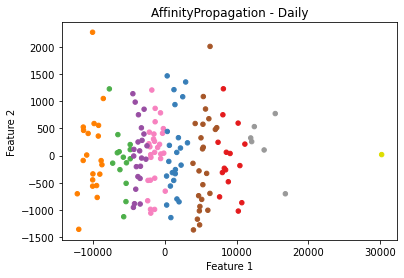

Data Set: Daily
Model: MeanShift


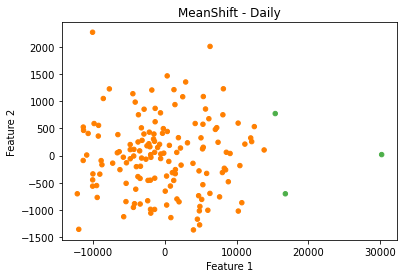

Data Set: Daily
Model: DBSCAN


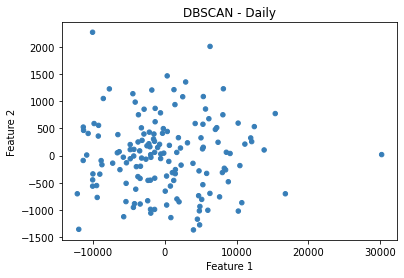

Data Set: Daily
Model: OPTICS


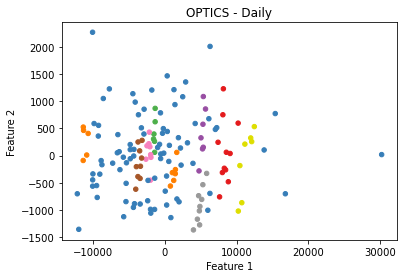

Data Set: Weekly
Model: AffinityPropagation


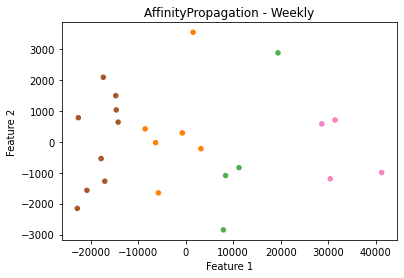

Data Set: Weekly
Model: MeanShift


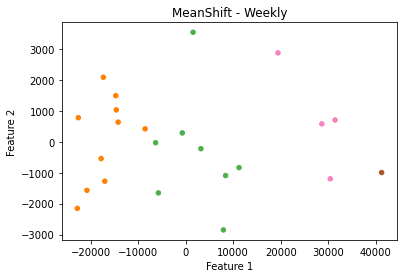

Data Set: Weekly
Model: DBSCAN


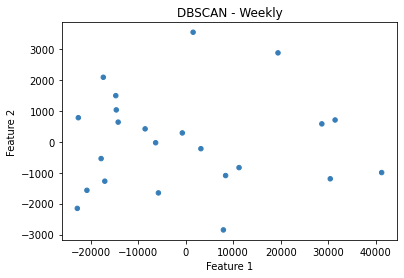

Data Set: Weekly
Model: OPTICS


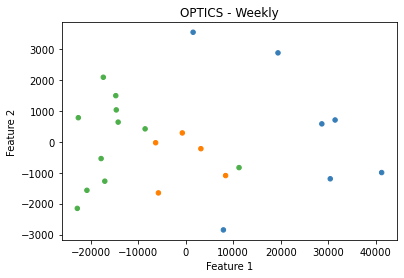

In [20]:
models = [AffinityPropagation(), MeanShift(), DBSCAN(), OPTICS()]
model_labels = ["AffinityPropagation", "MeanShift", "DBSCAN", "OPTICS"]

for df, df_lbl in zip(datasets, dataset_labels):
    for model, model_lbl in zip(models, model_labels):
        plot_clusters(df, df_lbl, model, model_lbl)

### Discussion

These cluster plots show us that our data exhibits few clustering patterns, evidenced by the discrepancies in the clustering outputs by the different clustering models. We see that the AffinityPropagation and OPTICS algorithms produce a greater number of distinct clusters than the MeanShift and DBSCAN algorithms.

## Conclusion

In this report, we analyzed health and fitness metrics scraped from my personal Garmin Connect account. The data was broken down by day and week, and spans the time period from mid-June to mid-November of 2021. 

We first looked at the correlations between features in each of the daily and weekly data sets. We found that intensity minutes, Calories burned, and steps were all positively correlated. We also discovered that the number of hours of sleep per night was negatively correlated with nearly every other feature, and was most significantly negatively correlated with stress level. Additionally, it was found that stress level and resting heart rate (BPM) are positively correlated. On a daily level, a higher number of intensity minutes is associated with a higher stress score. However, this does not play out on the weekly level.

Next, we performed dimension reduction on the daily and weekly data sets using principal component analysis (PCA) as well as singular value decomposition (SVD). We found that the PCA dimension-reduction slightly outperformed SVD across all dimensions. We discovered that dimension reduction in general appears effective on the data sets due to the inherent redundancy and high covariances between features.

Following the dimension reduction analysis, we turned our attention to regression. We wanted to find which features in our data sets could most effectively be predicted by regression, and which regression models proved to be most accurate. We performed a series of tests and found that the LinearRegression and Ridge models were most accurate on average across all tests. We also found that daily intensity minutes, daily Calories, and weekly stress level were the most fit for regression prediction. Interestingly, we also found that the regression models performed optimally when only a subset of features were used.

After the regression analysis, we performed a binary classification analysis on the same target features as in the regression tests. We created the binary classification labels by dividing the target feature into samples that fell above and below the median of that feature. Similar to the regression analysis, we performed tests iterating over different data sets, models, and target features. We found that the same features conducive to accurate regression prediction were conducive to accurate classification prediction. The most accurate binary classifier turned out to be the RandomForest classifier, but this came at the cost of having the most execution overhead. Intuitively, the overall binary classification accuracy was significantly better than the regression accuracy when predicting against the same features. This highlights the fact that prediction granularity and prediction accuracy are inversely related.

The last section of the report focused on the clustering of samples in our data sets. We performed clustering using four different algorithms on each of our data sets. We outputted the clustering results on 2D plots containing the dimension-reduced samples obtained from PCA dimension reduction discussed earlier in the report. We showed that our data sets offer no defining patterns that lead to consistent clusters. This is shown in the way that each clustering algorithm outputs vastly different clusters. Hence, it is proven difficult to decisively characterize and group distinctions in data samples across the daily and weekly time scales.

From a practical perspective, a key takeaway from our analysis is that intense training may increase acute stress, but does not result in significantly higher stress when observed over longer time periods. In addition, increased daily training is associated with lower resting heart rate levels which counteracts the rise in resting heart rate seen by more chronic stress. We also find the significance of sleep, highlighting its negative correlation with stress levels on both daily and weekly time scales. In addition, we find that we can relatively accurately predict metrics such as stress levels on a weekly time scale or intensity minutes in a given day.